In [107]:
import json
import os
from dotenv import load_dotenv, find_dotenv
import requests
import numpy as np
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GMapOptions, LabelSet, Label
from bokeh.plotting import gmap
from collections import defaultdict
from pathlib import Path

import networkx as nx

#env_path = Path('.') / '.env'
#load_dotenv(dotenv_path=env_path, override=True)
load_dotenv(find_dotenv())

True

### Call Lyft Developer API to pull ride cost information

For the moment only the basic Lyft ride type is being selected. Future updates can/should include other alternatives to provide more options.

In [108]:
url = 'https://api.lyft.com/oauth/token'
client_id = os.environ.get('Lyft_Client_ID')
client_secret = os.environ.get('Lyft_Client_Secret') 

# define request parameters
payload = {"Content-Type": "application/json",
           "grant_type": "client_credentials",
           "scope": "public"}
# request data
res = requests.post(url,
                    data = payload,
                    auth = (client_id, client_secret))
# extract the token from the response
token = res.json()['access_token']

In [109]:
def lyft_request(org_lat, org_long, end_lat, end_long, token, rtype='lyft'):
    query_url = 'https://api.lyft.com/v1/cost'
    header = {"Authorization": "Bearer {}".format(token)}
    payload = {'start_lat':org_lat, 'start_lng':org_long,
               'end_lat':end_lat, 'end_lng':end_long, 
               'ride_type':rtype
              }
    r = requests.get(query_url, params=payload, headers=header)
    return r

In [110]:
def lyft_eta(org_lat, org_long, token, rtype='lyft'):
    query_url = 'https://api.lyft.com/v1/eta'
    header = {"Authorization": "Bearer {}".format(token)}
    payload = {'lat':org_lat, 'lng':org_long, 
               'ride_type':rtype
              }
    r = requests.get(query_url, params=payload, headers=header)
    return r

In [111]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

### Transit Fare Information
Note: Using a dictionary with minimal information needed to get stuff working for now. In the future should be able to retrieve fare information via the MTA real-time feed --> http://datamine.mta.info/. 

In [112]:
fare_info = {'PATH':2.75, 'SUBWAY':2.75, 'BUS': 2.75}

### Using Google Maps API - retrieve route information. 

Transit fare information is not available for all rides. Google Maps will only return fare information if all 'TRANSIT' routes have fares. This is something that will need to be resolved for the full implementation. Currently, only Lyft ride cost data has been included. 

In [113]:
goog_api_key = os.environ.get('GOOG_API_KEY')
#origin = input("Start Location: ").replace(" ","+")
#dest = input("End Location: ").replace(" ","+")
#For test purpose
origin = "Journal Square, NJ"
origin = "Sheepshead Bay, Brooklyn, NY"
dest = "Laguardia, NY".replace(" ","+")

url = 'https://maps.googleapis.com/maps/api/directions/json'
pars = {'origin':origin,'destination':dest,'mode':'transit','key':goog_api_key}
r = requests.get(url, params=pars)

#try:
#    cost_cap = float(input("What is the preferred amount you would like to spend?"))
#except ValueError:
#    print("Not a number")
#try:
#    time_cap = float(input("How fast do you need to arrive?"))
#except ValueError:
#    print("Not a number")

constraints = (cost_cap, time_cap)
#goog_query = end_point + "origin={}&destination={}&mode=transit&key={}".format(origin,dest, goog_api_key)
#r = requests.get(goog_query)
if r.json()['status'] == 'OK':
    locator = r.json()
else:
    print("Something went wrong!")

## Computing Traversal Graph to enable mapping of routes

In [114]:
def compute_weight_L1(vals, const, sclfac, wage=0.217):
    """
    Compute weights using difference. Scaling by user defined constraint.
    Converting time into money, initially set by using the minimum wage.
    min_wage_ny = $13 /hr = $0.217 /min
    """
    user_cost, user_time = const
    user_cost, user_time = user_cost * sclfac, user_time * sclfac
    app_cost, app_time = vals
    user_time_conv, app_time_conv = user_time*wage, app_time*wage
    
    res = (app_cost - user_cost) / user_cost + (app_time_conv - user_time_conv) / user_time_conv
    fmt1 = "Res={:.2f},Res={:.2f}, Sclfac={:.2f}\n".format(np.exp(res),10**res,sclfac)
    fmt2 = "Cost={:.2f},UserCost={:.2f},Scaled_cost={:.2f}\n".format(app_cost,user_cost,(app_cost - user_cost) / user_cost)
    fmt3 = "Time={:.2f},UserTime={:.2f},Scaled_time={:.2f}\n".format(app_time_conv, user_time_conv, (app_time_conv - user_time_conv) / user_time_conv)
    print(fmt1, fmt2, fmt3)
    
    return np.exp(res)

In [146]:
locator['routes'][0]['legs'][0]['steps'][1]['transit_details']['arrival_stop']['name']

'34 Street-Herald Sq Station'

In [162]:
# To start out with, assume 50k salary, working 40 hours a week, and there are 52 working weeks in the year.
income_per_year = 150000.
income_per_hour = income_per_year / 40 / 52 
income_per_min = income_per_hour / 60

# Initiate Graph
G = nx.MultiDiGraph()

start_node = 0
end_node = len(locator['routes'][0]['legs'][0]['steps'])

start_location = locator['routes'][0]['legs'][0]['start_location']
end_location = locator['routes'][0]['legs'][0]['end_location']

start_lat, start_lng = start_location['lat'], start_location['lng']
stop_lat, stop_lng = end_location['lat'], end_location['lng']

lyft_r_eta = lyft_eta(start_lat, start_lng, token, rtype='lyft').json()
eta_step_0 = lyft_r_eta['eta_estimates'][0]['eta_seconds']/60.

lyft_r_step = lyft_request(start_lat, start_lng, stop_lat, stop_lng, token, rtype='lyft').json()
dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60.

price_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
price_dur = dur_step * income_per_min
price_eta = eta_step_0 * income_per_min

instruction = 'Take Lyft from origin to destination'
G.add_edge(start_node, end_node,weight=price_step + price_dur + price_eta, 
                           attr_dict={'cost':price_step, 'duration':dur_step, 
                                      'mode':'lyft', 'instructions':instruction})
G.node[start_node] = {'lat':start_lat, 'lng':start_lng}
G.node[end_node] = {'lat':stop_lat, 'lng':stop_lng}

for leg in locator['routes'][0]['legs']:
    tot_dist = leg['distance']['value']/1000
    for cnt, steps in enumerate(leg['steps']):
        print(cnt, steps['html_instructions'])
        
        # Starting latitude and longitude of the node
        step_lat, step_lng = steps['start_location']['lat'], steps['start_location']['lng']
        if cnt in G.nodes():
            G.node[cnt] = {'lat':step_lat, 'lng':step_lng}
        else:
            G.add_node(cnt, {'lat':step_lat, 'lng':step_lng})
        if cnt != 0 and not 'WALKING' in leg['steps'][cnt-1]['travel_mode']:
            mode = 'lyft'
            print(mode, 0, cnt)
            lyft_r_step = lyft_request(start_lat, start_lng, step_lat, step_lng, token, rtype='lyft').json()

            dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60.
            price_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
            
            price_dur = dur_step * income_per_min
            price_eta = eta_step_0 * income_per_min

            if 'WALKING' in steps['travel_mode']:
                step_name = steps['html_instructions'].strip("Walk to")
            else:
                step_name = steps['transit_details']['arrival_stop']['name']

            instruction = 'Take Lyft from origin to ' + step_name
            G.add_edge(start_node, cnt, weight=price_step + price_dur + price_eta, 
                           attr_dict={'cost':price_step, 'duration':dur_step, 
                                      'mode':mode, 'instructions':instruction})

            lyft_r_eta = lyft_eta(step_lat, step_lng, token, rtype='lyft').json()
            eta_step = lyft_r_eta['eta_estimates'][0]['eta_seconds']/60.

            lyft_r_step = lyft_request(step_lat, step_lng, stop_lat, stop_lng, token, rtype='lyft').json()
            dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60.
            price_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
            
            price_dur = dur_step * income_per_min
            price_eta = eta_step * income_per_min

            instruction = 'Take Lyft from ' + step_name + " to destination"
            G.add_edge(cnt, end_node, weight=price_step + price_dur + price_eta, 
                           attr_dict={'cost':price_step, 'duration':dur_step, 
                                      'mode':mode, 'instructions':instruction})
                        
        if 'WALKING' in steps['travel_mode']:
            mode = 'walking'
            print(mode,cnt, cnt+1)

            price_step = 0.
            dur_step = steps['duration']['value']/60
            price_dur = dur_step * income_per_min * 1.5
            price_eta = 5 * income_per_min * 1.5

            
            G.add_edge(cnt, cnt+1, weight=price_step + price_dur + price_eta, 
                           attr_dict={'cost':price_step, 'duration':dur_step, 
                                      'mode':mode, 'instructions':steps['html_instructions']})

            
        if 'TRANSIT' in steps['travel_mode']:
            mode = 'transit'
            print(mode,cnt, cnt+1)

            trans_det = steps['transit_details']['line']
            trans_short_name = trans_det['short_name']
            trans_name = trans_det['vehicle']['name']
            trans_type = trans_det['vehicle']['type']

            if 'PATH' in [trans_short_name,trans_name,trans_type]: price_step = fare_info['PATH']
            elif 'SUBWAY' in [trans_short_name,trans_name,trans_type]: price_step = fare_info['SUBWAY']
            elif 'BUS' in [trans_short_name,trans_name,trans_type]: price_step = fare_info['BUS']

            dur_step = steps['duration']['value']/60            
            price_dur = dur_step * income_per_min
            price_eta = 5 * income_per_min * 1.5

            
            G.add_edge(cnt, cnt+1, weight=price_step + price_dur + price_eta, 
                           attr_dict={'cost':price_step, 'duration':dur_step, 
                                      'mode':mode, 'instructions':steps['html_instructions']})


0 Walk to Avenue U
walking 0 1
1 Subway towards 145 St
transit 1 2
2 Walk to 34 Street-Herald Sq Station
lyft 0 2
walking 2 3
3 Subway towards Jamaica - 179 St
transit 3 4
4 Walk to 74 St/Roosevelt Av Station
lyft 0 4
walking 4 5
5 Bus towards +LaGuardia Link Select Bus Service LaGuardia Airport Terminals D-C-B
transit 5 6


In [100]:
nx.get_node_attributes(G,'lat')

{0: 40.5976176,
 1: 40.5993,
 2: 40.764664,
 3: 40.764664,
 4: 40.77026,
 5: 40.770207,
 6: 40.774196}

In [163]:
shortest = nx.dijkstra_path(G, source=start_node,target=end_node, weight='weight')

In [170]:
shortest

[0, 1, 2, 3, 4, 6]

In [176]:
for cnt in range(len(shortest)-1):
    print(shortest[cnt],shortest[cnt+1], G.get_edge_data(shortest[cnt],shortest[cnt+1])[0]['instructions'])

0 1 Walk to Avenue U
1 2 Subway towards 145 St
2 3 Walk to 34 Street-Herald Sq Station
3 4 Subway towards Jamaica - 179 St
4 6 Take Lyft from 74 St/Roosevelt Av Station to destination


In [23]:
# initiate multi-edge, directed Graph
G = nx.MultiDiGraph()

# Selecting 'nodes' or 'legs' according to Google API recommendations. 
# Moving from one leg to the next constitutes one edge in the graph.
node_start = 0
node_end = len(locator['routes'][0]['legs'][0]['steps'])
for leg in locator['routes'][0]['legs']:
    tot_dist = leg['distance']['value']/1000
    nsteps = len(leg['steps'])
    for cnt, steps in enumerate(leg['steps']):
        print(cnt, steps['html_instructions'])

        # Starting latitude and longitude of the node
        start_lat, start_lng = steps['start_location']['lat'], steps['start_location']['lng']
        transit_dist = steps['distance']['value']/1000
        # Computing the different steps per initial node for "Lyft".
        lyft_dist = 0
        for cnt2 in range(cnt, len(leg['steps'])):
            lyft_dist += leg['steps'][cnt2]['distance']['value']/1000
            # Logic for whether to call cab, if distance < 1km then do not call Lyft.
#            if dist < 1: short = True 
#            else: short = False
            if not 'WALKING' in leg['steps'][cnt2]['travel_mode']:
                mode = 'lyft'
                print(mode,cnt, cnt2+1)
                stop_lat, stop_lng = leg['steps'][cnt2]['end_location']['lat'], leg['steps'][cnt2]['end_location']['lng']

                lyft_r_eta = lyft_eta(start_lat, start_lng, token, rtype='lyft').json()
                dur_eta = lyft_r_eta['eta_estimates'][0]['eta_seconds']/60.
                
                lyft_r_step = lyft_request(start_lat, start_lng, stop_lat, stop_lng, token, rtype='lyft').json()
                
                cost_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
                dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60. + dur_eta

                weight = compute_weight_L1((cost_step,dur_step), constraints, lyft_dist/tot_dist)
                G.add_edge(cnt, cnt2+1,weight=weight, 
                           attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})
        if 'WALKING' in steps['travel_mode']:
            mode = 'walking'
            print(mode,cnt, cnt+1)

            cost_step = 0.
            dur_step = steps['duration']['value']/60
            weight = compute_weight_L1((cost_step,dur_step), constraints, 1/nsteps)
            G.add_edge(cnt, cnt+1, weight=weight, 
                       attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})

        if 'TRANSIT' in steps['travel_mode']:
            mode = 'transit'
            print(mode,cnt, cnt+1)

            trans_det = steps['transit_details']['line']
            print(trans_det)
            trans_short_name = trans_det['short_name']
            trans_name = trans_det['vehicle']['name']
            trans_type = trans_det['vehicle']['type']

            if 'PATH' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['PATH']
            elif 'SUBWAY' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['SUBWAY']
            elif 'BUS' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['BUS']

            dur_step = steps['duration']['value']/60

            weight = compute_weight_L1((cost_step,dur_step), constraints, transit_dist/tot_dist)

            G.add_edge(cnt, cnt+1, weight=weight, 
                       attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})


0 Walk to Journal Square
lyft 0 2
Res=43.52,Res=5930.96, Sclfac=0.43
 Cost=40.00,UserCost=12.83,Scaled_cost=2.12
 Time=7.40,UserTime=2.78,Scaled_time=1.66

lyft 0 4
Res=11.09,Res=254.69, Sclfac=0.80
 Cost=60.00,UserCost=23.98,Scaled_cost=1.50
 Time=9.91,UserTime=5.20,Scaled_time=0.90

lyft 0 6
Res=4.08,Res=25.47, Sclfac=1.00
 Cost=55.00,UserCost=30.00,Scaled_cost=0.83
 Time=10.24,UserTime=6.51,Scaled_time=0.57

walking 0 1
Res=0.32,Res=0.07, Sclfac=0.17
 Cost=0.00,UserCost=5.00,Scaled_cost=-1.00
 Time=0.93,UserTime=1.08,Scaled_time=-0.14

1 Train towards 33rd via Hoboken
lyft 1 2
Res=52.21,Res=9023.02, Sclfac=0.41
 Cost=40.00,UserCost=12.44,Scaled_cost=2.22
 Time=7.39,UserTime=2.70,Scaled_time=1.74

lyft 1 4
Res=9.80,Res=191.76, Sclfac=0.79
 Cost=55.00,UserCost=23.59,Scaled_cost=1.33
 Time=9.99,UserTime=5.12,Scaled_time=0.95

lyft 1 6
Res=4.29,Res=28.66, Sclfac=0.99
 Cost=55.00,UserCost=29.60,Scaled_cost=0.86
 Time=10.27,UserTime=6.42,Scaled_time=0.60

transit 1 2
{'agencies': [{'name'

In [10]:
shortest = nx.dijkstra_path(G, source=0,target=6, weight='weight')
nx.dijkstra_path(G, source=0,target=6, weight='weight')

[0, 1, 2, 3, 4, 5, 6]

In [26]:
G[0]

{1: {0: {'cost': 0.0,
   'duration': 4.283333333333333,
   'mode': 'walking',
   'weight': 0.31875473321004555}},
 2: {0: {'cost': 40.0,
   'duration': 34.083333333333336,
   'mode': 'lyft',
   'weight': 43.515843383069402}},
 4: {0: {'cost': 60.0,
   'duration': 45.666666666666664,
   'mode': 'lyft',
   'weight': 11.089732129341312}},
 6: {0: {'cost': 55.0,
   'duration': 47.18333333333333,
   'mode': 'lyft',
   'weight': 4.0800576210026493}}}

In [88]:
for edge in G.edges():
    print(edge, G.get_edge_data(edge[0],edge[1]))

(0, 2) {0: {'cost': 60.0, 'duration': 61.75, 'mode': 'lyft', 'weight': 49.338514966250337}}
(0, 4) {0: {'cost': 65.0, 'duration': 57.56666666666667, 'mode': 'lyft', 'weight': 7.7436893187636455}}
(0, 6) {0: {'cost': 65.0, 'duration': 57.583333333333336, 'mode': 'lyft', 'weight': 4.2473544055535184}}
(0, 1) {0: {'cost': 0.0, 'duration': 5.3, 'mode': 'walking', 'weight': 0.27435474139712746}}
(2, 4) {0: {'cost': 28.0, 'duration': 25.316666666666666, 'mode': 'lyft', 'weight': 28.393209141460201}}
(2, 6) {0: {'cost': 40.0, 'duration': 27.15, 'mode': 'lyft', 'weight': 12.448896406748508}}
(2, 3) {0: {'cost': 0.0, 'duration': 0.0, 'mode': 'walking', 'weight': 0.1353352832366127}}
(4, 6) {0: {'cost': 12.0, 'duration': 8.216666666666667, 'mode': 'lyft', 'weight': 6.843107444701741}}
(4, 5) {0: {'cost': 0.0, 'duration': 0.6166666666666667, 'mode': 'walking', 'weight': 0.14693311764031941}}
(1, 2) {0: {'cost': 60.0, 'duration': 60.93333333333333, 'mode': 'lyft', 'weight': 54.400906418279938}, 1:

In [41]:
for i, edge in enumerate(shortest[:-1]):
    print (edge, shortest[i+1], G.get_edge_data(edge,shortest[i+1]))

0 1 {0: {'cost': 0.0, 'duration': 4.283333333333333, 'mode': 'walking', 'weight': 0.09987216039048306}}
1 2 {0: {'cost': 42.0, 'duration': 39.61666666666667, 'mode': 'lyft', 'weight': 49050.739136174474}, 1: {'cost': 2.75, 'duration': 20.0, 'mode': 'transit', 'weight': 1.1902460804222805}}
2 3 {0: {'cost': 0.0, 'duration': 0.4666666666666667, 'mode': 'walking', 'weight': 0.012849578706819883}}
3 4 {0: {'cost': 15.0, 'duration': 20.85, 'mode': 'lyft', 'weight': 244078540.36156482}, 1: {'cost': 2.75, 'duration': 7.5, 'mode': 'transit', 'weight': 12.428420629720987}}
4 5 {0: {'cost': 30.0, 'duration': 34.68333333333333, 'mode': 'lyft', 'weight': 9192.108694291972}, 1: {'cost': 2.75, 'duration': 11.5, 'mode': 'transit', 'weight': 0.2596435055448767}}
5 6 {0: {'cost': 0.0, 'duration': 1.0666666666666667, 'mode': 'walking', 'weight': 0.017737356253670455}}
6 7 {0: {'cost': 15.0, 'duration': 13.916666666666666, 'mode': 'lyft', 'weight': 113.33262405055646}, 1: {'cost': 2.75, 'duration': 11.0,

### Plotting route information using Bokeh interface to Google Maps

In [8]:
from bokeh.models import HoverTool
output_notebook() 
#output_file("Lyft_Cost.html") 

map_lat_ne, map_lng_ne = locator['routes'][0]['bounds']['northeast']['lat'], locator['routes'][0]['bounds']['northeast']['lng']
map_lat_sw, map_lng_sw = locator['routes'][0]['bounds']['southwest']['lat'], locator['routes'][0]['bounds']['southwest']['lng']
map_lat = np.mean([map_lat_ne,map_lat_sw])
map_lng = np.mean([map_lng_ne,map_lng_sw])

map_options = GMapOptions(lat=map_lat, lng=map_lng, map_type="roadmap", zoom=11)
p = gmap(goog_api_key, map_options)

source = ColumnDataSource(
    data=dict(data_plot))

p.line(x="lon", y="lat", line_width=5, source=source)
p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

labels = LabelSet(x='lon', y='lat', text='cost_statement', level='glyph',
              x_offset=0, y_offset=-20, source=source, render_mode='canvas',
                 background_fill_color='white', background_fill_alpha=1.0)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("Cost", "$cost_statement"),
    ("Lat, Long", "($lat, $lon)")
]
hover.mode = 'mouse'

#p.add_layout(labels)
show(p)
export_png(p, filename="LyftCost.png")

Loading BokehJS ...

'/Users/arajan/repos/QuickCommute/LyftCost.png'

In [48]:
def compute_weight_L1_var2(vals, const, sclfac, wage=0.217):
    """
    Compute weights using difference. Scaling by user defined constraint.
    Converting time into money, initially set by using the minimum wage.
    min_wage_ny = $13 /hr = $0.217 /min
    """
    user_cost, user_time = const
    user_cost, user_time = user_cost * sclfac, user_time * sclfac
    app_cost, app_time = vals
    user_time_conv, app_time_conv = user_time*wage, app_time*wage
    
    res = (app_cost - user_cost) / user_cost + (app_time_conv - user_time_conv) / user_time_conv
    fmt1 = "Res={:.2f}, Sclfac={:.2f}\n".format((1+np.exp(-res))**-1,sclfac)
    fmt2 = "Cost={:.2f},UserCost={:.2f},Scaled_cost={:.2f}\n".format(app_cost,user_cost,(app_cost - user_cost) / user_cost)
    fmt3 = "Time={:.2f},UserTime={:.2f},Scaled_time={:.2f}\n".format(app_time_conv, user_time_conv, (app_time_conv - user_time_conv) / user_time_conv)
    print(fmt1,fmt2,fmt3)
    
    return (1+np.exp(-res))**-1

In [49]:
# initiate multi-edge, directed Graph
G = nx.MultiDiGraph()

# Selecting 'nodes' or 'legs' according to Google API recommendations. 
# Moving from one leg to the next constitutes one edge in the graph.
for leg in locator['routes'][0]['legs']:
    tot_dist = leg['distance']['value']/1000
    nsteps = len(leg['steps'])
    for cnt, steps in enumerate(leg['steps']):
        print(cnt, steps['html_instructions'])

        # Starting latitude and longitude of the node
        start_lat, start_lng = steps['start_location']['lat'], steps['start_location']['lng']
        transit_dist = steps['distance']['value']/1000
        # Computing the different steps per initial node for "Lyft".
        lyft_dist = 0
        for cnt2 in range(cnt, len(leg['steps'])):
            lyft_dist += leg['steps'][cnt2]['distance']['value']/1000
            # Logic for whether to call cab, if distance < 1km then do not call Lyft.
#            if dist < 1: short = True 
#            else: short = False
            if not 'WALKING' in leg['steps'][cnt2]['travel_mode']:
                mode = 'lyft'
                print(mode,cnt, cnt2+1)
                stop_lat, stop_lng = leg['steps'][cnt2]['end_location']['lat'], leg['steps'][cnt2]['end_location']['lng']

                lyft_r_eta = lyft_eta(start_lat, start_lng, token, rtype='lyft').json()
                dur_eta = lyft_r_eta['eta_estimates'][0]['eta_seconds']/60.
                
                lyft_r_step = lyft_request(start_lat, start_lng, stop_lat, stop_lng, token, rtype='lyft').json()
                
                cost_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
                dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60. + dur_eta

                weight = compute_weight_L1_var2((cost_step,dur_step), constraints, lyft_dist/tot_dist)
                G.add_edge(cnt, cnt2+1,weight=weight, 
                           attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})
        if 'WALKING' in steps['travel_mode']:
            mode = 'walking'
            print(mode,cnt, cnt+1)

            cost_step = 0.
            dur_step = steps['duration']['value']/60
            weight = compute_weight_L1_var2((cost_step,dur_step), constraints, 1/nsteps)
            G.add_edge(cnt, cnt+1, weight=weight, 
                       attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})

        if 'TRANSIT' in steps['travel_mode']:
            mode = 'transit'
            print(mode,cnt, cnt+1)

            trans_det = steps['transit_details']['line']
            trans_short_name = trans_det['short_name']
            trans_name = trans_det['vehicle']['name']
            trans_type = trans_det['vehicle']['type']

            if 'PATH' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['PATH']
            elif 'SUBWAY' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['SUBWAY']
            elif 'BUS' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['BUS']

            dur_step = steps['duration']['value']/60

            weight = compute_weight_L1_var2((cost_step,dur_step), constraints, transit_dist/tot_dist)

            G.add_edge(cnt, cnt+1, weight=weight, 
                       attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})


0 Walk to Journal Square
lyft 0 2
Res=0.99, Sclfac=0.37
 Cost=40.00,UserCost=14.69,Scaled_cost=1.72
 Time=8.56,UserTime=2.39,Scaled_time=2.58

lyft 0 4
Res=0.98, Sclfac=0.47
 Cost=45.00,UserCost=18.85,Scaled_cost=1.39
 Time=10.14,UserTime=3.07,Scaled_time=2.31

lyft 0 5
Res=0.92, Sclfac=0.79
 Cost=65.00,UserCost=31.63,Scaled_cost=1.05
 Time=12.26,UserTime=5.15,Scaled_time=1.38

lyft 0 7
Res=0.81, Sclfac=1.00
 Cost=65.00,UserCost=40.00,Scaled_cost=0.63
 Time=12.08,UserTime=6.51,Scaled_time=0.86

walking 0 1
Res=0.27, Sclfac=0.14
 Cost=0.00,UserCost=5.71,Scaled_cost=-1.00
 Time=0.93,UserTime=0.93,Scaled_time=-0.00

1 Train towards 33rd Street
lyft 1 2
Res=0.99, Sclfac=0.35
 Cost=40.00,UserCost=14.17,Scaled_cost=1.82
 Time=8.79,UserTime=2.31,Scaled_time=2.81

lyft 1 4
Res=0.98, Sclfac=0.46
 Cost=45.00,UserCost=18.33,Scaled_cost=1.45
 Time=10.59,UserTime=2.98,Scaled_time=2.55

lyft 1 5
Res=0.93, Sclfac=0.78
 Cost=65.00,UserCost=31.12,Scaled_cost=1.09
 Time=12.57,UserTime=5.06,Scaled_time=1

In [44]:
shortest = nx.dijkstra_path(G, source=0,target=7, weight='weight')
nx.dijkstra_path(G, source=0,target=7, weight='weight')

[0, 7]

In [45]:
for i, edge in enumerate(shortest[:-1]):
    print (edge, shortest[i+1], G.get_edge_data(edge,shortest[i+1]))

0 7 {0: {'cost': 60.0, 'duration': 50.78333333333333, 'mode': 'lyft', 'weight': 0.76723749942322772}}


/Users/arajan/anaconda/envs/astro3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/arajan/anaconda/envs/astro3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/arajan/anaconda/envs/astro3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/arajan/anaconda/envs/astro3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, wil

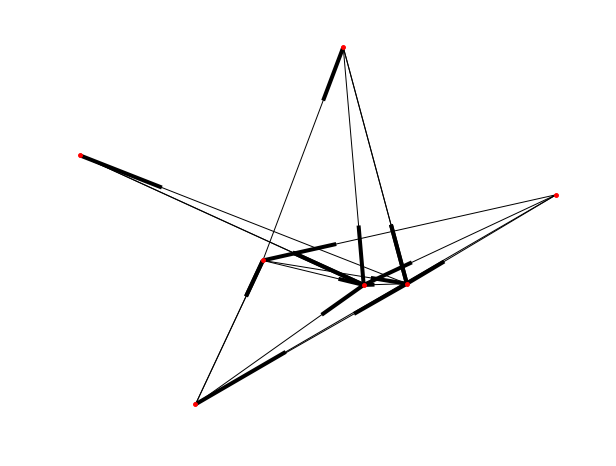

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
nx.draw(G, node_size=15)

In [108]:
def compute_weight_L2_var(vals, const, sclfac, wage=0.217):
    """
    Compute weights using sum of squared error. Scaling by user defined constraint.
    Converting time into money, initially set by using the minimum wage.
    min_wage_ny = $13 /hr = $0.217 /min
    """
    user_cost, user_time = const
    user_cost, user_time = user_cost/ sclfac, user_time/sclfac
    app_cost, app_time = vals
    user_time_conv, app_time_conv = user_time, app_time #*wage, app_time*wage

    res = ((app_cost - user_cost) / user_cost)**2 + ((app_time_conv - user_time_conv) / user_time_conv)**2
    print(res, ((app_cost - user_cost) / user_cost)**2, ((app_time_conv - user_time_conv) / user_time_conv)**2)
    return res

In [2]:
def compute_weight_L1_var(vals, const):
    """
    Compute weights using difference, and sigmoid function. Scaling by user defined constraint.
    """
    res = 0
    user_cost, user_time = const
    app_cost, app_time = vals
    res = (app_cost - user_cost) / user_cost + (app_time - user_time) / user_time
    return (1+np.exp(-res))**-1

In [25]:
def compute_weight_L2(vals, const):
    """
    Compute weights using sum of squared error. Scaling by user defined constraint.
    """
    res = 0
    user_cost, user_time = const
    app_cost, app_time = vals
    res = ((app_cost - user_cost) / user_cost)**2 + ((app_time - user_time) / user_time)**2
    return res

### Generate all paths given above graph.

In [ ]:
def paths(graph, v):
    """Generate the maximal cycle-free paths in graph starting at v.
    graph must be a mapping from vertices to collections of
    neighbouring vertices.
    """
    path = [v]                  # path traversed so far
    seen = {v}                  # set of vertices in path
    def search():
        dead_end = True
        for neighbour in graph[path[-1]]:
            if neighbour not in seen:
                dead_end = False
                seen.add(neighbour)
                path.append(neighbour)
                yield from search()
                path.pop()
                seen.remove(neighbour)
        if dead_end:
            yield list(path)
    yield from search()

In [9]:
a = []
b = []
for leg in locator['routes'][0]['legs']:
    for cnt, steps in enumerate(leg['steps']): 
        if 'TRANSIT' in steps['travel_mode']: 
            a.append(cnt)
            a.append(cnt+100)
            b.append(cnt+100)
        else: a.append(cnt)
a.append(cnt+1)
new_graph = dict.fromkeys(a)

In [10]:
fin_lat, fin_lng = locator['routes'][0]['legs'][0]['end_location']['lat'], locator['routes'][0]['legs'][0]['end_location']['lng']
lyft_cntr = 0

for leg in locator['routes'][0]['legs']:
    for cnt, steps in enumerate(leg['steps']): 
        print (cnt)
        start_lat, start_lng = steps['start_location']['lat'], steps['start_location']['lng']
        stop_lat, stop_lng = steps['end_location']['lat'], steps['end_location']['lng']
        lyft_r_fin = lyft_request(start_lat, start_lng, fin_lat, fin_lng, token, rtype='lyft').json()
        cost_fin = lyft_r_fin['cost_estimates'][0]['estimated_cost_cents_max']/100.
        dur_fin = lyft_r_fin['cost_estimates'][0]['estimated_duration_seconds']/60.

        dist = steps['distance']['value']/1000
        if dist < 1: short = True
        else: short = False

        if new_graph[cnt] is None: 
            new_graph[cnt] = [[a[-1],dur_fin,cost_fin]]
        else: 
            new_graph[cnt].append([a[-1],dur_fin,cost_fin])
        
        if cnt < a[-1]-1:
            if cnt in new_graph.keys() and 'WALKING' in steps['travel_mode']:
                new_graph[cnt] = [cnt+1,steps['duration']['value']/60, 0.]

            print(cnt, steps['html_instructions'])
            if cnt in new_graph.keys() and 'TRANSIT' in steps['travel_mode']:
                trans_det = steps['transit_details']['line']
                trans_short_name = trans_det['short_name']
                trans_name = trans_det['vehicle']['name']
                trans_type = trans_det['vehicle']['type']

                if 'PATH' in [trans_short_name,trans_name,trans_type]: cost = fare_info['PATH']
                elif 'SUBWAY' in [trans_short_name,trans_name,trans_type]: cost = fare_info['SUBWAY']
                elif 'BUS' in [trans_short_name,trans_name,trans_type]: cost = fare_info['BUS']

                if new_graph[cnt] is None: 
                    new_graph[cnt] = [[cnt+1,steps['duration']['value']/60,0.,cost]]
                else: 
                    new_graph[cnt].append([cnt+1,steps['duration']['value']/60,0.,cost])

                if not short:
                    lyft_r_step = lyft_request(start_lat, start_lng, stop_lat, stop_lng, token, rtype='lyft').json()
                    cost_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
                    dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60.
                    if new_graph[b[lyft_cntr]] is None: 
                        new_graph[b[lyft_cntr]] = [[b[lyft_cntr+1],dur_step,cost_step]]
                    else: 
                        new_graph[b[lyft_cntr]].append([b[lyft_cntr+1],dur_step,cost_step])
                    lyft_cntr += 1

                if new_graph[b[lyft_cntr]] is None and lyft_cntr != len(b): 
                    new_graph[b[lyft_cntr]] = [[a[-1],dur_fin,cost_fin]]
                elif new_graph[b[lyft_cntr]] is not None and lyft_cntr != len(b):
                    new_graph[b[lyft_cntr]].append([a[-1],dur_fin,cost_fin])


0
0 Walk to Journal Square
1
1 Train towards World Trade Center
2
2 Walk to Path Station World Trade Center
3
3 Subway towards Jamaica Center - Parsons/Archer
4
4 Walk to 74 St/Roosevelt Av Station
5


In [42]:
G.get_edge_data(5,6)

{0: {'cost': 15.0,
  'duration': 17.416666666666668,
  'mode': 'lyft',
  'weight': 0.24731891343190876},
 1: {'cost': 2.75,
  'duration': 12.0,
  'mode': 'transit',
  'weight': 0.16223840653035346}}

### Plotting route info using Folium

In [23]:
# initiate multi-edge, directed Graph
G = nx.MultiDiGraph()

# Selecting 'nodes' or 'legs' according to Google API recommendations. 
# Moving from one leg to the next constitutes one edge in the graph.
node_start = 0
node_end = len(locator['routes'][0]['legs'][0]['steps'])
for leg in locator['routes'][0]['legs']:
    tot_dist = leg['distance']['value']/1000
    nsteps = len(leg['steps'])
    for cnt, steps in enumerate(leg['steps']):
        print(cnt, steps['html_instructions'])

        # Starting latitude and longitude of the node
        start_lat, start_lng = steps['start_location']['lat'], steps['start_location']['lng']
        transit_dist = steps['distance']['value']/1000
        # Computing the different steps per initial node for "Lyft".
        lyft_dist = 0
        for cnt2 in range(cnt, len(leg['steps'])):
            lyft_dist += leg['steps'][cnt2]['distance']['value']/1000
            # Logic for whether to call cab, if distance < 1km then do not call Lyft.
#            if dist < 1: short = True 
#            else: short = False
            if not 'WALKING' in leg['steps'][cnt2]['travel_mode']:
                mode = 'lyft'
                print(mode,cnt, cnt2+1)
                stop_lat, stop_lng = leg['steps'][cnt2]['end_location']['lat'], leg['steps'][cnt2]['end_location']['lng']

                lyft_r_eta = lyft_eta(start_lat, start_lng, token, rtype='lyft').json()
                dur_eta = lyft_r_eta['eta_estimates'][0]['eta_seconds']/60.
                
                lyft_r_step = lyft_request(start_lat, start_lng, stop_lat, stop_lng, token, rtype='lyft').json()
                
                cost_step = lyft_r_step['cost_estimates'][0]['estimated_cost_cents_max']/100.
                dur_step = lyft_r_step['cost_estimates'][0]['estimated_duration_seconds']/60. + dur_eta

                weight = compute_weight_L1((cost_step,dur_step), constraints, lyft_dist/tot_dist)
                G.add_edge(cnt, cnt2+1,weight=weight, 
                           attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})
        if 'WALKING' in steps['travel_mode']:
            mode = 'walking'
            print(mode,cnt, cnt+1)

            cost_step = 0.
            dur_step = steps['duration']['value']/60
            weight = compute_weight_L1((cost_step,dur_step), constraints, 1/nsteps)
            G.add_edge(cnt, cnt+1, weight=weight, 
                       attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})

        if 'TRANSIT' in steps['travel_mode']:
            mode = 'transit'
            print(mode,cnt, cnt+1)

            trans_det = steps['transit_details']['line']
            print(trans_det)
            trans_short_name = trans_det['short_name']
            trans_name = trans_det['vehicle']['name']
            trans_type = trans_det['vehicle']['type']

            if 'PATH' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['PATH']
            elif 'SUBWAY' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['SUBWAY']
            elif 'BUS' in [trans_short_name,trans_name,trans_type]: cost_step = fare_info['BUS']

            dur_step = steps['duration']['value']/60

            weight = compute_weight_L1((cost_step,dur_step), constraints, transit_dist/tot_dist)

            G.add_edge(cnt, cnt+1, weight=weight, 
                       attr_dict={'cost':cost_step, 'duration':dur_step, 'mode':mode})


0 Walk to Journal Square
lyft 0 2
Res=43.52,Res=5930.96, Sclfac=0.43
 Cost=40.00,UserCost=12.83,Scaled_cost=2.12
 Time=7.40,UserTime=2.78,Scaled_time=1.66

lyft 0 4
Res=11.09,Res=254.69, Sclfac=0.80
 Cost=60.00,UserCost=23.98,Scaled_cost=1.50
 Time=9.91,UserTime=5.20,Scaled_time=0.90

lyft 0 6
Res=4.08,Res=25.47, Sclfac=1.00
 Cost=55.00,UserCost=30.00,Scaled_cost=0.83
 Time=10.24,UserTime=6.51,Scaled_time=0.57

walking 0 1
Res=0.32,Res=0.07, Sclfac=0.17
 Cost=0.00,UserCost=5.00,Scaled_cost=-1.00
 Time=0.93,UserTime=1.08,Scaled_time=-0.14

1 Train towards 33rd via Hoboken
lyft 1 2
Res=52.21,Res=9023.02, Sclfac=0.41
 Cost=40.00,UserCost=12.44,Scaled_cost=2.22
 Time=7.39,UserTime=2.70,Scaled_time=1.74

lyft 1 4
Res=9.80,Res=191.76, Sclfac=0.79
 Cost=55.00,UserCost=23.59,Scaled_cost=1.33
 Time=9.99,UserTime=5.12,Scaled_time=0.95

lyft 1 6
Res=4.29,Res=28.66, Sclfac=0.99
 Cost=55.00,UserCost=29.60,Scaled_cost=0.86
 Time=10.27,UserTime=6.42,Scaled_time=0.60

transit 1 2
{'agencies': [{'name'

In [44]:
import folium

In [45]:
start_lat, start_lng

(40.746515, -73.890689)

In [46]:
map_osm = folium.Map(location=[start_lat, start_lng])

map_osm.save('figures/map.html')